In [1]:
import numpy as np
import pyjags
import pandas as pd
import matplotlib.pyplot as plt
import corner
%matplotlib notebook

In [2]:
#To read the files, if needed
def readCODA(findex,fchain):
    names=np.loadtxt(findex, usecols=[0], dtype=str,ndmin=1)
    print names.shape
    
    names=np.array(names)
    try:
        n_vars=len(names)
    except:
        n_vars=1
    raw_table=np.loadtxt(fchain,usecols=[1])
    #print raw_table.shape
    table=raw_table.reshape([-1,n_vars],order='F')
    #print table.shape
    df = pd.DataFrame(table, columns=names)
    return df
    #names,i_start,i_stop = np.loadtxt(findex, unpack=True,format="")
  
#pyjags returns a dictionary, we translate it to Pandas
def from_dict2pd(sample, nchain=-1):
    new_dict=dict()
    for key in sample:
        aa=sample[key]
        aa_shape=aa.shape
        #First dimension is the dimension of the array of samples
        #Second dimension is the length of the chain
        # Third dimension is the number of chains
        if nchain >= aa_shape[2]:
            print "Error You asked the chain larger than your number of chains"
            return
        
        
        for i in range(aa_shape[0]):
            if aa_shape[0] > 1:
                print "Variable %s is an array of dimension %d"%(key,aa_shape[0])
                new_key="%s_%02d"%(key,i)
            else:
                new_key=key
                
            if nchain == -1:
                bb=aa[i,:,:].flatten()
            else:
                try:
                    bb=aa[i,:,nchain]
                except:
                    print "Index out of limit"
                    return
                
            new_dict[new_key]=bb
            print "Added key "+new_key
        
            
        
    sample_pd=pd.DataFrame.from_dict(new_dict)
    return sample_pd

In [49]:
#Make contour plots using corner
def contour_plot(x, y):
    fig, axes = plt.subplots(1, 1)
    #corner.hist2d(x.values, y.values, levels=[0.682689492, 0.954499736], \
    #              plot_datapoints=False, plot_density=False, ax=axes, color='blue')
    corner.hist2d(x.values, y.values, levels=[0.682689492, 0.954499736, 0.997], \
                  plot_datapoints=False, plot_density=True, ax=axes, color='blue')
    
    axes.set_xlabel(x.name);
    axes.set_ylabel(y.name);

In [4]:
#set up
n_chains=3
used_chain=2

In [8]:
#Read data from file Using Pandas
input_data=pd.read_csv("data_planck.txt", dtype=float)
#Test the conversion to dictionary
print input_data.to_dict('list').keys()

 ['errlogYSZ', 'obslogM', 'obslogYSZ', 'errlogM', 'Ez']


In [29]:
print input_data['obslogYSZ'].describe()
print input_data['obslogM'].describe()
print input_data['Ez'].describe()


count    71.000000
mean     -5.143549
std       0.295864
min      -5.989000
25%      -5.328500
50%      -5.131000
75%      -4.957000
max      -4.441000
Name: obslogYSZ, dtype: float64
count    71.000000
mean     14.786070
std       0.160214
min      14.379000
25%      14.686000
50%      14.786000
75%      14.884500
max      15.196000
Name: obslogM, dtype: float64
count    71.000000
mean      1.104972
std       0.067420
min       1.021000
25%       1.041000
50%       1.093000
75%       1.158000
max       1.268000
Name: Ez, dtype: float64


<IPython.core.display.Javascript object>


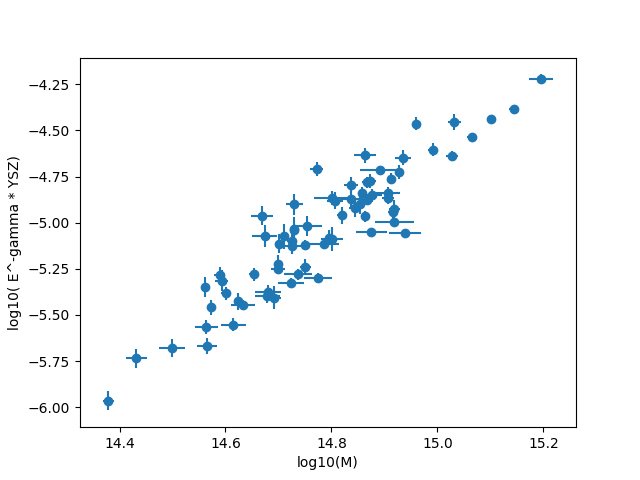

Text(0,0.5,u'log10( E^-gamma * YSZ)')

In [62]:
gamma=2.5
plt.figure()
plt.subplot(111)
plt.errorbar(input_data['obslogM'], input_data['obslogYSZ']+gamma*np.log10(input_data['Ez']), 
             xerr=input_data['errlogM'], yerr=input_data['errlogYSZ'], 
             capsize=0, fmt='o')
plt.xlabel("log10(M)")
plt.ylabel("log10( E^-gamma * YSZ)")

#*np.log10


In [41]:
print input_data['obslogYSZ'].describe()

count    71.000000
mean     -5.143549
std       0.295864
min      -5.989000
25%      -5.328500
50%      -5.131000
75%      -4.957000
max      -4.441000
Name: obslogYSZ, dtype: float64


In [42]:
#PyJags run

#Code
code = '''
model {
    for (i in 1:length(obslogM))
    {
        logM[i] ~ dunif(13,17)
        obslogM[i] ~ dnorm(logM[i], pow(errlogM[i],-2))
        obslogYSZ[i] ~ dnorm(logYSZ[i], pow(errlogYSZ[i], -2))
        logYSZ[i] ~ dnorm(z[i], 1./sigma/sigma)
        z[i] <- A + beta * (logM[i] - 14.778) + gamma * log(Ez[i])/2.303
    }
    
    A ~ dnorm(0,1e-6)
    beta ~ dt(0,1,1)
    sigma ~ dunif(0,3)
    gamma ~ dt(0,1,1)
}
'''

#B is distributed as Student-T distribution with one degree of fredom, this is uniform in the angle

model = pyjags.Model(code, data=input_data.to_dict('list'),
                     chains=n_chains,generate_data=True, adapt=3000) 
# equivalent in data file to obsn <- c (8,4,3,5) Use c to indicate it is a struture !!

#Update
model.update(3000)

#Makes the runs
samples = model.sample(100000, vars=['A','beta','sigma','gamma'], thin=10)


adapting: iterations 9000 of 9000, elapsed 0:00:02, remaining 0:00:00
updating: iterations 9000 of 9000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 50433 of 300000, elapsed 0:00:09, remaining 0:00:46
sampling: iterations 105168 of 300000, elapsed 0:00:19, remaining 0:00:35
sampling: iterations 132684 of 300000, elapsed 0:00:24, remaining 0:00:31
sampling: iterations 160023 of 300000, elapsed 0:00:29, remaining 0:00:26
sampling: iterations 187362 of 300000, elapsed 0:00:34, remaining 0:00:21
sampling: iterations 214650 of 300000, elapsed 0:00:40, remaining 0:00:16
sampling: iterations 241803 of 300000, elapsed 0:00:46, remaining 0:00:11
sampling: iterations 294528 of 300000, elapsed 0:00:55, remaining 0:00:01
sampling: iterations 300000 of 300000, elapsed 0:00:56, remaining 0:00:00


In [43]:
#Translate the output dictionary to Pandas
samples_pd=from_dict2pd(samples,used_chain)

Added key A
Added key beta
Added key sigma
Added key gamma


In [44]:
#Show the parameters
for kk in samples_pd.keys():
    print samples_pd[kk].describe()
    print " "


count    10000.000000
mean        -5.255631
std          0.020397
min         -5.343244
25%         -5.269063
50%         -5.255481
75%         -5.241940
max         -5.166704
Name: A, dtype: float64
 
count    10000.000000
mean         1.510116
std          0.069723
min          1.238175
25%          1.464092
50%          1.509951
75%          1.557791
max          1.782595
Name: beta, dtype: float64
 
count    10000.000000
mean         2.442045
std          0.447464
min          0.756757
25%          2.146696
50%          2.442401
75%          2.738365
max          4.162449
Name: gamma, dtype: float64
 
count    10000.000000
mean         0.059053
std          0.008452
min          0.031346
25%          0.053298
50%          0.058689
75%          0.064509
max          0.096805
Name: sigma, dtype: float64
 


<IPython.core.display.Javascript object>


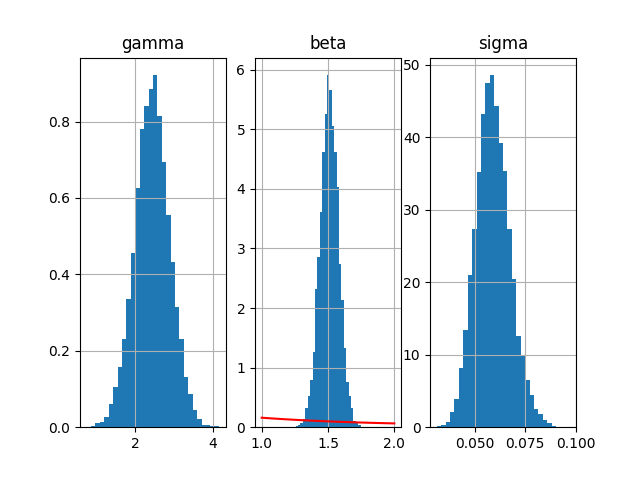

Text(0.5,1,u'sigma')

In [54]:
from scipy.stats import t as stud_t

# Just Histograms
plt.figure()
plt.subplot(1,3,1)
ax1=samples_pd['gamma'].hist(bins=30, normed=True, label="gamma")
ax1.set_title("gamma")

plt.subplot(1,3,2)
ax2=samples_pd['beta'].hist(bins=30, normed=True, label="beta")
ax2.set_title("beta")

xx = np.linspace(1,2,100)


yy=stud_t.pdf(xx, 1)
#print yy
plt.plot(xx,yy,color='red')
#ax2.set_ylim([0,10])

plt.subplot(1,3,3)
ax3=samples_pd['sigma'].hist(bins=30, normed=True, label="sigma")
ax3.set_title("sigma")


<IPython.core.display.Javascript object>


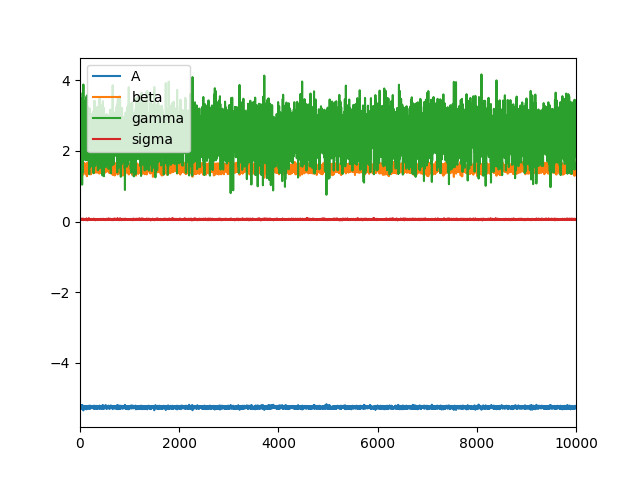

In [45]:
#Traces
samples_pd.plot()

<IPython.core.display.Javascript object>


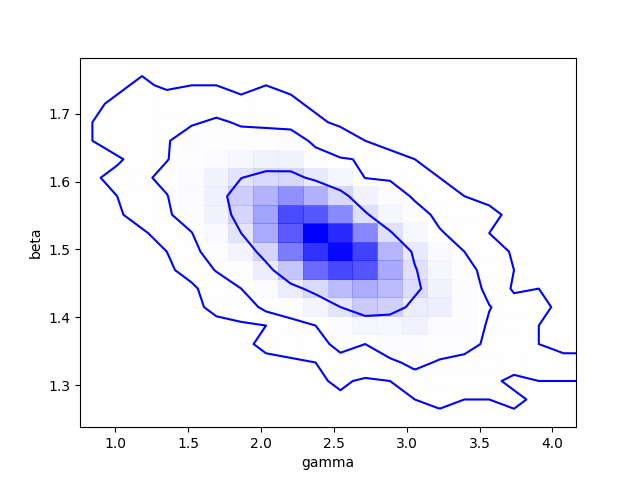

In [50]:
#Plot one contour
contour_plot(x=samples_pd['gamma'], y=samples_pd['beta'])


<IPython.core.display.Javascript object>


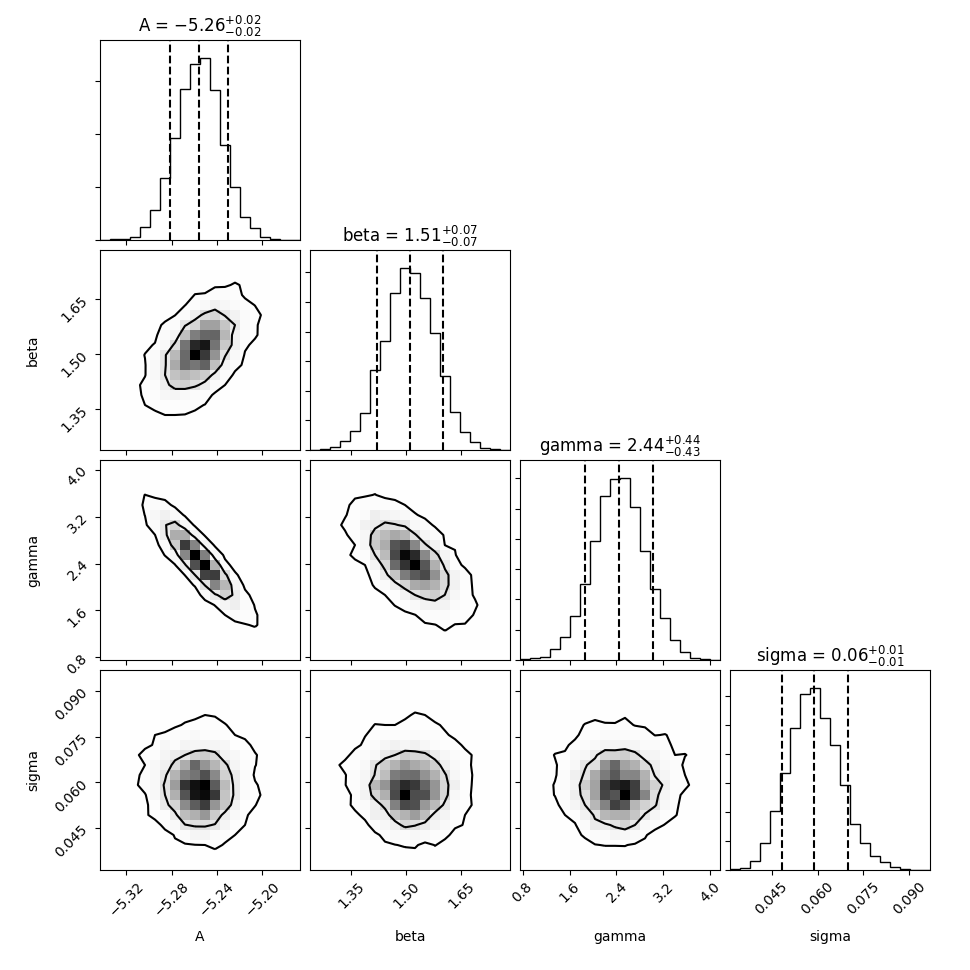

In [47]:
#Make the corner plot
def corner_from_pd(samples_pd):
    n_var=len(samples_pd.keys())
    n_sample=len(samples_pd.index)
    
    data=np.zeros([n_sample,n_var])
    for i, kk in enumerate(samples_pd.keys()):
        data[:,i]=samples_pd[kk].values
    corner.corner(data, labels=samples_pd.keys(),
                        quantiles=[0.1, 0.5, 0.9],
                        show_titles=True,levels=[0.682689492, 0.954499736],
                        plot_datapoints=False, )
corner_from_pd(samples_pd)

In [63]:
print input_data.keys()

Index([u'obslogM', u'obslogYSZ', u'errlogYSZ', u'Ez', u'errlogM'], dtype='object')


<IPython.core.display.Javascript object>


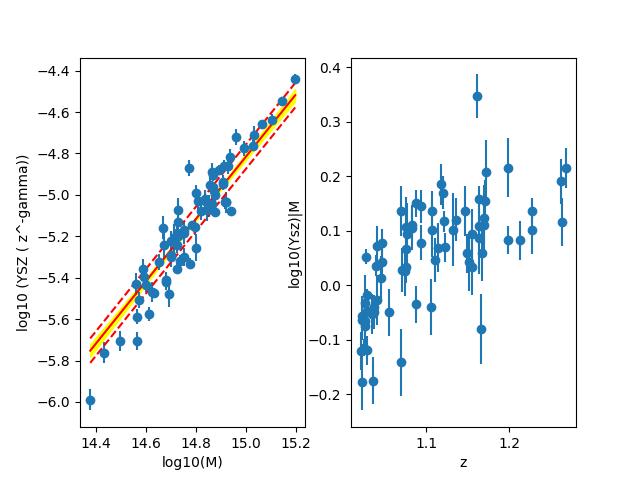

{u'A': -5.2556313791823399, u'beta': 1.5101164914059695, u'sigma': 0.059052655213484163, u'gamma': 2.4420449490794773}
{u'A': -5.1965787239688561, u'beta': 1.5101164914059695, u'sigma': 0.059052655213484163, u'gamma': 2.4420449490794773}


Text(0.5,0,u'z')

In [71]:
#Write the model using python 
from scipy.special import erf

def efficiency(x,z, params):
    A=params['A']
    B=params['beta']
    gamma = params['gamma']
    sigma=params['sigma']
    #z[i] <- A + beta * (logM[i] - 14.778) + gamma * log(Ez[i])/2.303
    return A + B*(x-14.778) + gamma * np.log10(z.mean())

gamma=samples_pd['gamma'].mean()

#Plots the Data
plt.figure()
plt.subplot(121)
x=input_data['obslogM'].values
dx=input_data['errlogM'].values
ind = x.argsort()
y=input_data['obslogYSZ'].values 
dy=input_data['errlogYSZ'].values

z=input_data['Ez'].values

x=x[ind]
y=y[ind]
dx=dx[ind]
dy=dy[ind]
z=z[ind]

ax1=plt.errorbar(x,y,yerr=dy, capsize=0, fmt='o')
plt.ylabel('log10 (YSZ ( z^-gamma))')
plt.xlabel('log10(M)')

#Define a dictionary with parameters
best_params=dict.fromkeys(samples.keys())
for kk in samples.keys():
    best_params[kk]=samples_pd[kk].values.mean()

#Plots the regression
y_model = efficiency(x,z,best_params)
plt.plot(x,y_model, color='red')

#Computes the confidence interval
n_samples=len(samples_pd.index)
n_x=len(x)

tmp_array=np.zeros([n_samples,n_x])
params=dict.fromkeys(samples.keys())
#print tmp_array.shape
for i in range(n_samples):
    for kk in samples.keys():
        params[kk]=samples_pd[kk].values[i]
        #print params[kk]    
    tmp_array[i,:]=efficiency(x,z,params)

#Here we use the standard deviation as a proxy of the 68% percentile
error = tmp_array.std(axis=0)
ax2=plt.fill_between(x, efficiency(x,z,best_params)-error, efficiency(x,z,best_params)+error, color='yellow')

print best_params
# plots 1-sigma of instrinsic scatter
best_params['A']=best_params['A']+samples_pd['sigma'].values.mean()
y_model = efficiency(x,z,best_params)
plt.plot(x,y_model, color='red', linestyle='--')
print best_params

best_params['A']=best_params['A']-2*samples_pd['sigma'].values.mean()
y_model = efficiency(x,z,best_params)
plt.plot(x,y_model, color='red', linestyle='--')

plt.subplot(122)
plt.errorbar(z,y-efficiency(x,z,best_params), yerr=dy, capsize=0, fmt='o')
#plt.plot(z,efficiency(x,z,best_params),color='red')
plt.ylabel("log10(Ysz)|M")
plt.xlabel("z")
